# Energy management test with Ipopt

PH, July 2020

In [71]:
using Ipopt
using ECOS
using JuMP
using PyPlot

┌ Info: Precompiling ECOS [e2685f51-7e38-5353-a97d-a921fd2c8199]
└ @ Base loading.jl:1260


In [5]:
model = Model(Ipopt.Optimizer)
@variable(model, x, start = 0.0)
@variable(model, y, start = 0.0)

@NLobjective(model, Min, (1 - x)^2 + 100 * (y - x^2)^2)

optimize!(model)
println("x = ", value(x), " y = ", value(y))

# adding a (linear) constraint
@constraint(model, x + y == 10)
optimize!(model)
println("x = ", value(x), " y = ", value(y))

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [29]:
collect(0:3-1)

3-element Array{Int64,1}:
 0
 1
 2

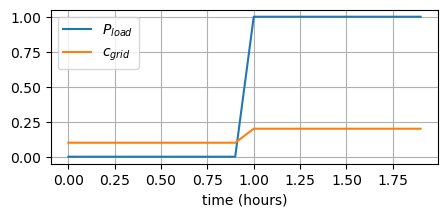

In [153]:
n = 2*10
dt = 0.1
t = (0:n-1)*dt;
E_rated = 1.2 # kWh
P_grid_max = 1.5 # kW
P_load = [zeros(n÷2)
          ones(n÷2)]
c_grid = [ones(n÷2)*0.1
          ones(n÷2)*0.2] # €/kWh

figure(figsize=(5,2.))
plot(t, P_load, label="\$P_{load}\$")
plot(t, c_grid, label="\$c_{grid}\$")
xlabel("time (hours)")
legend()
grid(true)

### 1. LP version: no losses, small P_grid discount for unicity

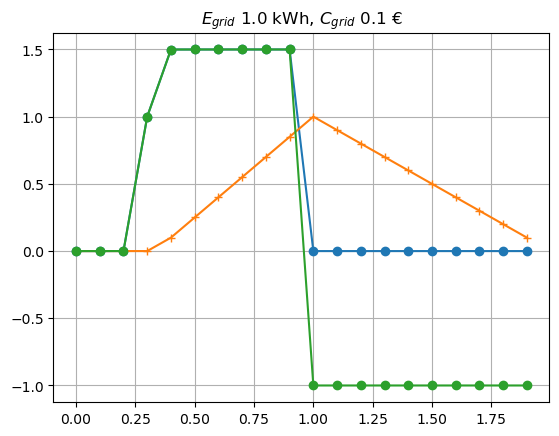

In [154]:
m = Model(ECOS.Optimizer)
# silence solver output
set_silent(m)

@variable(m, 0 <= E[1:n+1] <= E_rated)
@variable(m, 0 <= P_grid[1:n] <= P_grid_max)
@variable(m, P_sto[1:n])

@constraint(m, Edyn[k = 1:n], 
            E[k+1] == E[k] + P_sto[k]*dt)
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_sto[k] + P_load[k])

@constraint(m, Eini, E[1] == 0.)

seq0_1 = (0:n-1)/(n-1) # increasing sequence from 0 to 1 on k=1:n
discount = (1 .- seq0_1) * 1e-5

@objective(m, Min, sum(P_grid .* c_grid) + sum(P_grid .* discount))

# Optimize and check result
optimize!(m)
if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
    error("The model was not solved correctly.")
end

P_grid = value.(P_grid)
P_sto = value.(P_sto)
E_sto = value.(E)

E_grid = round(sum(P_grid)*dt, digits=6)
C_grid = round(sum(P_grid .* c_grid)*dt, digits=6)

plot(t, P_grid, "o-")
plot(t, E_sto[1:end-1], "+-")
plot(t, P_sto, "o-")

title("\$E_{grid}\$ $E_grid kWh, \$C_{grid}\$ $C_grid €")
grid(true)

### 2. SOCP version: no losses, penalty for RMS value of $P_{sto}$

RMS value of the storage power, in discrete time:

$$ P_{sto,rms} = \sqrt{\sum_{k=1}^n P_{sto}^2(k)/n} = \lVert P_{sto} \rVert / \sqrt{n}$$

This can be written as a SOC constraint

$$ \lVert P_{sto} \rVert \leq P_{sto,rms}.\sqrt{n} $$

In [155]:
#?SecondOrderCone

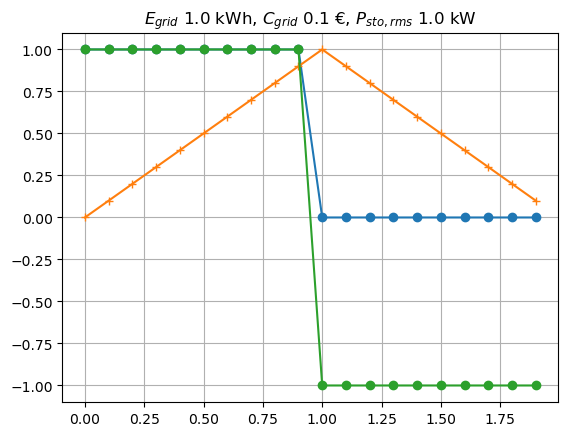

In [156]:
m = Model(ECOS.Optimizer)
# silence solver output
set_silent(m)

@variable(m, 0 <= E[1:n+1] <= E_rated)
@variable(m, 0 <= P_grid[1:n] <= P_grid_max)
@variable(m, P_sto[1:n])
@variable(m, P_sto_rms)

@constraint(m, Edyn[k = 1:n], 
            E[k+1] == E[k] + P_sto[k]*dt)
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_sto[k] + P_load[k])

@constraint(m, Eini, E[1] == 0.)
@constraint(m, [P_sto_rms*sqrt(n); P_sto] in SecondOrderCone())

@objective(m, Min, sum(P_grid .* c_grid) + P_sto_rms*0.1)

# Optimize and check result
optimize!(m)
if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
    error("The model was not solved correctly.")
end

P_grid = value.(P_grid)
P_sto = value.(P_sto)
E_sto = value.(E)

E_grid = round(sum(P_grid)*dt, digits=6)
C_grid = round(sum(P_grid .* c_grid)*dt, digits=6)
P_sto_rms = round(value(P_sto_rms), digits=6)

plot(t, P_grid, "o-")
plot(t, E_sto[1:end-1], "+-")
plot(t, P_sto, "o-")

title("\$E_{grid}\$ $E_grid kWh, \$C_{grid}\$ $C_grid €, \$P_{sto,rms}\$ $P_sto_rms kW")
grid(true)

### 3. QCQP version: quadratic losses

Quadratic loss model

$$P_{loss} = R_0 P_{sto}^2$$

**Note** why does it work with ECOS? I thought ECOS only accepted SOC constraints, not generic quadratic ones

**IDEA** increase losses up to the point arbitrage is not profitable

In [157]:
R0 = 0.1 # kW/kW²

0.1

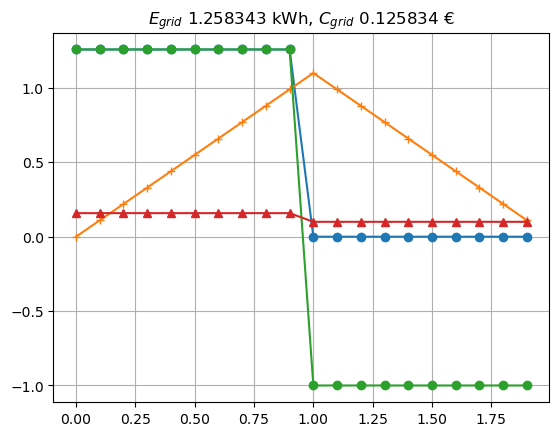

In [158]:
m = Model(ECOS.Optimizer)
# silence solver output
set_silent(m)

@variable(m, 0 <= E[1:n+1] <= E_rated)
@variable(m, 0 <= P_grid[1:n] <= P_grid_max)
@variable(m, P_sto[1:n])

# Quadratic loss expression
P_loss = R0 * P_sto.^2

@constraint(m, Edyn[k = 1:n], 
            E[k+1] <= E[k] + (P_sto[k] - P_loss[k])*dt)
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_sto[k] + P_load[k])

@constraint(m, Eini, E[1] == 0.)

@objective(m, Min, sum(P_grid .* c_grid))

# Optimize and check result
optimize!(m)
if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
    error("The model was not solved correctly.")
end

P_grid = value.(P_grid)
P_sto = value.(P_sto)
E_sto = value.(E)
P_loss = value.(P_loss)

E_grid = round(sum(P_grid)*dt, digits=6)
C_grid = round(sum(P_grid .* c_grid)*dt, digits=6)

plot(t, P_grid, "o-")
plot(t, E_sto[1:end-1], "+-")
plot(t, P_sto, "o-")
plot(t, P_loss, "^-")

title("\$E_{grid}\$ $E_grid kWh, \$C_{grid}\$ $C_grid €")
grid(true)

Check that there are not excess of losses

In [159]:
P_excess = (E_sto[2:end] - E_sto[1:end-1])/dt - P_sto + P_loss
maximum(abs.(P_excess))

3.7551936560298316e-10

### 4. NLP version: convex losses R(SoE).$P_{sto}^2$

See JuMP doc on [Nonlinear Modeling](https://jump.dev/JuMP.jl/v0.21.1/nlp/)


$$P_{loss} = \frac{R_0}{(1.01-SoE)^a} P_{sto}^2$$

**Note** why does it work with ECOS? I thought ECOS only accepted SOC constraints, not generic quadratic ones

In [160]:
R0 = 0.1 # kW/kW²
a = 0.5

0.5

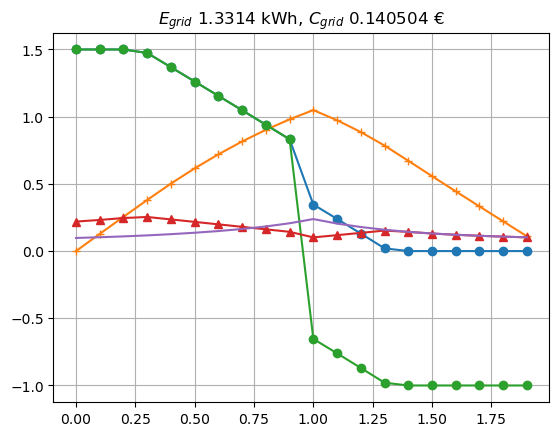

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       41
Number of nonzeros in inequality constraint Jacobian.:       60
Number of nonzeros in Lagrangian Hessian.............:       20

Total number of variables............................:       61
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       41
                     variables with only upper bounds:        0
Total number of equality constraints.................:       21
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [167]:
m = Model(Ipopt.Optimizer)
# silence solver output
set_silent(m)

@variable(m, 0 <= E[1:n+1] <= E_rated)
@variable(m, 0 <= P_grid[1:n] <= P_grid_max)
@variable(m, P_sto[1:n])

# Quadratic loss expression
@NLexpression(m, R_SoE[k = 1:n], R0/(1.05 - E_sto[k]/E_rated)^a)
@NLexpression(m, P_loss[k = 1:n], R_SoE[k] * P_sto[k]^2)

@NLconstraint(m, Edyn[k = 1:n], 
            E[k+1] <= E[k] + (P_sto[k] - P_loss[k])*dt)
@constraint(m, Pcons[k = 1:n],
            P_grid[k] == P_sto[k] + P_load[k])

@constraint(m, Eini, E[1] == 0.)

@objective(m, Min, sum(P_grid .* c_grid))

# Optimize and check result
optimize!(m)
if termination_status(m) != MOI.OPTIMAL &&  termination_status(m) != MOI.LOCALLY_SOLVED
    error("The model was not solved correctly.")
end

P_grid = value.(P_grid)
P_sto = value.(P_sto)
E_sto = value.(E)
P_loss = value.(P_loss)
R_SoE = value.(R_SoE)

E_grid = round(sum(P_grid)*dt, digits=6)
C_grid = round(sum(P_grid .* c_grid)*dt, digits=6)

plot(t, P_grid, "o-", label="\$P_{grid}\$")
plot(t, E_sto[1:end-1], "+-", label="\$E_{sto}\$")
plot(t, P_sto, "o-", label="\$P_{sto}\$")
plot(t, P_loss, "^-")
plot(t, R_SoE, "-")

title("\$E_{grid}\$ $E_grid kWh, \$C_{grid}\$ $C_grid €")
grid(true)

In [163]:
P_excess = (E_sto[2:end] - E_sto[1:end-1])/dt - P_sto + P_loss
maximum(abs.(P_excess))

1.6712874086055596e-7

In [165]:
[dual.(Edyn) dual.(Pcons)]

20×2 Array{Float64,2}:
 -1.52468  0.10783
 -1.52468  0.105382
 -1.52468  0.102508
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.1
 -1.52468  0.2
 -1.52468  0.2
 -1.52468  0.2
 -1.52468  0.2
 -1.52468  0.196096
 -1.52468  0.192366
 -1.52468  0.189482
 -1.52468  0.187164
 -1.52468  0.185246
 -1.52468  0.183623